# Fitting distribution of workplace size

This is an exercise on fitting real, in this case the distribution of company sizes in Denmark (in terms of FTE workers). This distribution was used in relation to Covid-19 modelling, but is in itself interresting.

You only need to consider the first two columns (size and frequency), as the rest is just derived from there.

NOTE: When extracting data from Statistics Denmark (DK: Danmarks Statistik), bins with less than 5 entries are by law not allowed to be revealed (to protect from ability to single out persons/companies), and are shown as NaN (Not a Number).

### References
Data from Statistics Denmark (contact: Laust Hvas Mortensen)

### Authors
Troels C. Petersen (NBI, petersen@nbi.dk)

### Date
04-12-2023 (latest update)

***

In [1]:
from __future__ import division, print_function

import sys
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from iminuit import Minuit
from scipy import stats
import pandas as pd
from scipy import interpolate

sys.path.append('../../AppStat2023/External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

In [2]:
save_plots = False   # For now, don't save plots (once you trust your code, switch on)
verbose = True       # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10        # But only print a lot for the first 10 random numbers

### Load data

In [3]:
data_test = pd.read_csv("TableData_Denmark2020.txt", header=0, sep=' ', index_col=0)

print(data_test.head(10))
print("...")
print(data_test.tail(10))

# Two 1D arrays:
Nworkers = np.arange(1, 200)
Ncompanies = data_test["Frequency"].iloc[1:200].values  # "values" yields numpy arrays, while nothing gives a Pandas series
eNcompanies = np.sqrt(Ncompanies)         # NOT CORRECT - what uncertainty to assign here?

minPlot = 1
maxPlot = 100


        Frequency  Percent  Cumulative  Frequency.1  Cumulative.1  Percent.1
ANTNOV                                                                      
0         20696.0     9.29       20696         9.29           NaN        NaN
1         52418.0    23.52       73114        32.80           NaN        NaN
2         27431.0    12.31      100545        45.11           NaN        NaN
3         17242.0     7.74      117787        52.84           NaN        NaN
4         13090.0     5.87      130877        58.72           NaN        NaN
5         10325.0     4.63      141202        63.35           NaN        NaN
6          8465.0     3.80      149667        67.15           NaN        NaN
7          6891.0     3.09      156558        70.24           NaN        NaN
8          5841.0     2.62      162399        72.86           NaN        NaN
9          4816.0     2.16      167215        75.02           NaN        NaN
...
        Frequency  Percent  Cumulative  Frequency.1  Cumulative.1  Perce

### Plotting the size distribution of companies

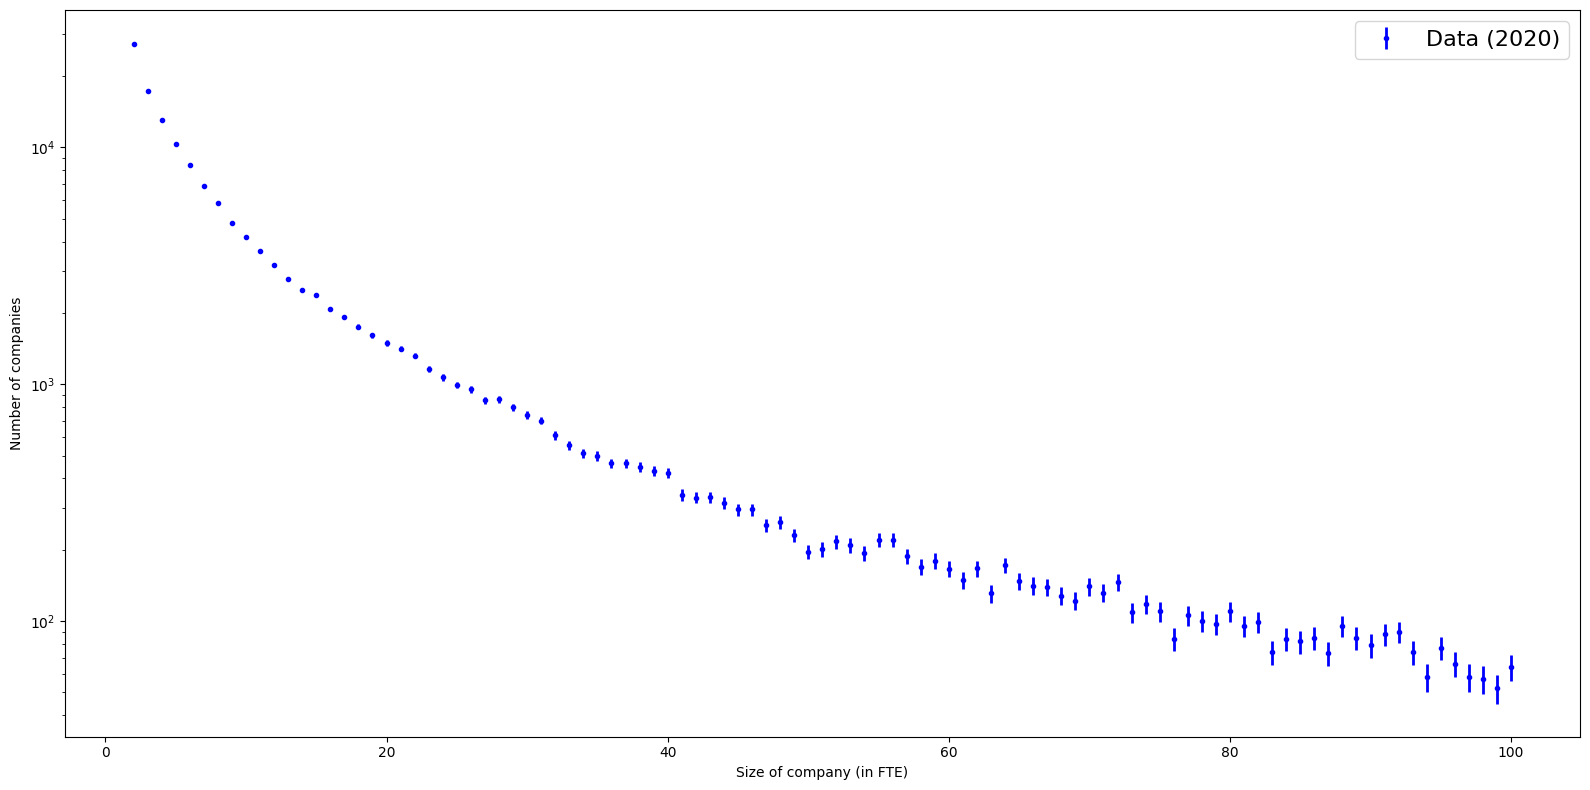

In [4]:
# Number of companies with a given size as a function of size:
fig_Ncompanies, ax_Ncompanies = plt.subplots(figsize=(16, 8))
ax_Ncompanies.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
ax_Ncompanies.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                  label='Data (2020)', color='blue')
ax_Ncompanies.legend(fontsize=16) #loc=(0.05, 0.75))

plt.yscale('log')
plt.tight_layout()
plt.show(block=False)

if (save_plots):
    plt.savefig("fig_DistNcompanies.pdf")

## Models

What is the best model for this distribution? Try the below models, and make better alternatives yourself.

In [5]:
# Power Law model:
def func_PowerLaw(x, N, alpha):
    return N * x ** (-alpha)

func_PowerLaw_vec = np.vectorize(func_PowerLaw)

In [6]:
# Exponential model:
def func_Exponential(x, N, alpha):
    return N * np.exp(-alpha * x)

func_Exponential_vec = np.vectorize(func_Exponential)

In [7]:
# Combined model:
def func_Combined(x1, N1, alpha1, N2, alpha2):
    return N1 * x1 ** (-alpha1) + N2 * np.exp(-alpha2 * x1)

func_Combined_vec = np.vectorize(func_Combined)

### Fit to data with Power Law


  ------------------------------------  Fitting Stage  --------------------------------------- 

Fit value (exp): N1 = 62909.32946 +/- 744.29559
Fit value (exp): alpha1 = 1.46683 +/- 0.00482
Fit value (exp): N2 = 6620.68363 +/- 141.99193
Fit value (exp): alpha2 = 0.11020 +/- 0.00145
  Model fit:  Prob(Chi2= 373.6, Ndof=195) = 0.00000


<Axes: xlabel='Size of company (in FTE)', ylabel='Number of companies'>

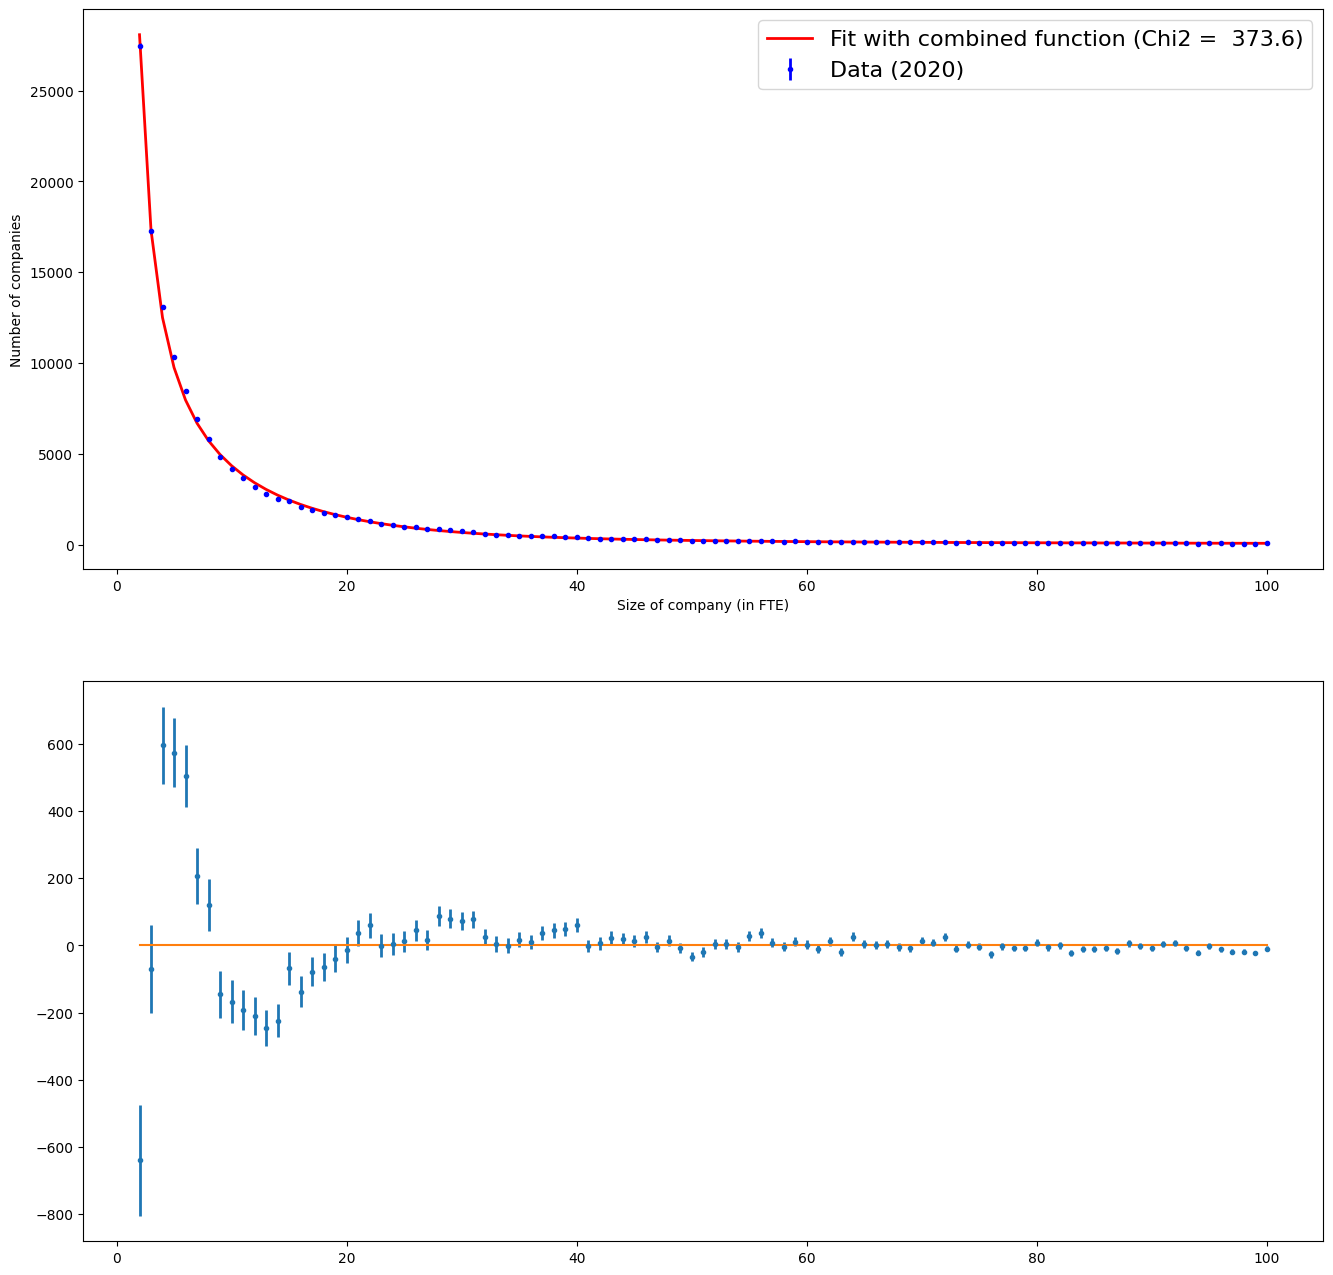

In [8]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

minFit = 1
maxFit = 100

# Plot data points again
fig_fit, ax = plt.subplots(nrows=2, figsize=(16, 16))
ax_fit, ax_res = ax
ax_fit.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")


# Power Law fit:
# --------------
def ChiSquarePowerLaw(N, alpha):
    Ncompanies_est = func_PowerLaw(Nworkers[minFit:maxFit], N, alpha)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

def ChiSquareExponential(N, alpha):
    Ncompanies_est = func_Exponential(Nworkers[minFit:maxFit], N, alpha)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

def ChiSquareCombined(N1, alpha1, N2, alpha2):
    Ncompanies_est = func_Combined(Nworkers[minFit:maxFit], N1, alpha1, N2, alpha2)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

minuit = Minuit(ChiSquareCombined, N1=25000.0, alpha1=2.0, N2=25000.0, alpha2=2.0)
minuit.errordef = 1.0   # Chi2 fit
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Ncompanies) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

N_fit1, alpha_fit1, N_fit2, alpha_fit2 = minuit.values[:]
eN_fit1, ealpha_fit1, eN_fit2, ealpha_fit2 = minuit.errors[:]
#ax_fit.plot(Nworkers[minFit:maxFit], func_PowerLaw_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
            #label=f'Fit with Power Law (Chi2 = {chi2:6.1f})')
#ax_fit.plot(Nworkers[minFit:maxFit], func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
            #label=f'Fit with Exponential (Chi2 = {chi2:6.1f})')
ax_fit.plot(Nworkers[minFit:maxFit], func_Combined_vec(Nworkers[minFit:maxFit], N_fit1, alpha_fit1, N_fit2, alpha_fit2), 'red', linewidth=2.0,
            label=f'Fit with combined function (Chi2 = {chi2:6.1f})')
#ax_res.errorbar(Nworkers[minFit:maxFit], Ncompanies[minPlot:maxPlot]-func_PowerLaw_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2)
#ax_res.errorbar(Nworkers[minFit:maxFit], Ncompanies[minPlot:maxPlot]-func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2)
ax_res.errorbar(Nworkers[minFit:maxFit], Ncompanies[minPlot:maxPlot]-func_Combined_vec(Nworkers[minFit:maxFit], N_fit1, alpha_fit1, N_fit2, alpha_fit2), yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2)
ax_res.plot(Nworkers[minFit:maxFit], np.zeros(len(Nworkers[minFit:maxFit])))
ax_fit.legend(fontsize=16);
ax_fit

In [9]:
N_employ = np.arange(101, 151)
N_company = func_Combined_vec(N_employ, N_fit1, alpha_fit1, N_fit2, alpha_fit2)

total_companies = np.sum(N_company)
print(f"The total number of companies with 101-150 workers are according to the fit {np.round(total_companies,0)}")

total_companies_data = np.sum(Ncompanies[100:150])
print(f"The total number of companies with 101-150 workers are according to the data {total_companies_data}")

difference = (total_companies-total_companies_data)/total_companies_data * 100
print(f"So the model predicts {difference:.2f} % too many workers")

The total number of companies with 101-150 workers are according to the fit 2692.0
The total number of companies with 101-150 workers are according to the data 1853.0
So the model predicts 45.28 % too many workers


In [10]:
if (save_plots):
    plt.savefig("fig_NworkersInDKcompanies_Fit.pdf")

# Questions

1. Try to fit the data (in the range 1-100) with a power law, an exponential, and a combination of the two. Are you satisfied with the results? Perhaps include a new plot of the residuals (i.e. data - fit) below the one showing the fit itself.

I get the best result with a combination of the two but it is still not very good as the p-value is essentially zero. But given the high statistics of the histogram, it is not suprising that a model with only 4 parameters doesn't fit the data very well.

2. Can you think of any other function that would fit throught the data better? Try to expand on the functions by adding more complexity and parameters, and see how well you can do. Do you manage to reach a "good" model, and how would you define one such?

???

3. From a "good" fit, try to predict how many companies there are with 101-150 employes. Compare this number to the data, and see how well you manage.

According to the model there are 2692 companies with 101-150 workers. According to the data there are 1853 companies with 101-150 workers. So the model predicts 45.28 % too many workers.

# Learning points:

From this exercise you should become capable of fitting data (in histogram) with many different (possibly similar) models, and evaluate their performance. From the last question, you should also become capable of extrapolating to obtain an estimate of the number of larger companies.